# Chapter 15: The Sports Analytics case study

In [18]:
import pandas as pd
import seaborn as sns
import json
from urllib import request

## Get the data

In [19]:
shots_url = 'https://www.murach.com/python_analysis/shots.json'
shots = request.urlretrieve(shots_url, filename='shots.json')

In [20]:
with open('shots.json') as jsonData:
    shots = json.load(jsonData)
shots.keys()

dict_keys(['resource', 'parameters', 'resultSets'])

In [21]:
columnHeaders = shots['resultSets'][0]['headers']
columnHeaders = [x.lower() for x in columnHeaders]
columnHeaders

['grid_type',
 'game_id',
 'game_event_id',
 'player_id',
 'player_name',
 'team_id',
 'team_name',
 'period',
 'minutes_remaining',
 'seconds_remaining',
 'event_type',
 'action_type',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'shot_distance',
 'loc_x',
 'loc_y',
 'shot_attempted_flag',
 'shot_made_flag',
 'game_date',
 'htm',
 'vtm']

In [22]:
rows = shots['resultSets'][0]['rowSet']

In [23]:
df = pd.DataFrame(data=rows, columns=columnHeaders)
df

,grid_type,game_id,game_event_id,player_id,player_name,team_id,team_name,period,minutes_remaining,seconds_remaining,...,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_attempted_flag,shot_made_flag,game_date,htm,vtm
0,Shot Chart Detail,0020900015,4,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,25,...,Right Side Center(RC),24+ ft.,26,99,249,1,0,20091028,GSW,HOU
1,Shot Chart Detail,0020900015,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,31,...,Left Side Center(LC),16-24 ft.,18,-122,145,1,1,20091028,GSW,HOU
2,Shot Chart Detail,0020900015,53,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,2,...,Center(C),8-16 ft.,14,-60,129,1,0,20091028,GSW,HOU
3,Shot Chart Detail,0020900015,141,201939,Stephen Curry,1610612744,Golden State Warriors,2,9,49,...,Left Side(L),16-24 ft.,19,-172,82,1,0,20091028,GSW,HOU
4,Shot Chart Detail,0020900015,249,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,19,...,Left Side Center(LC),16-24 ft.,16,-68,148,1,0,20091028,GSW,HOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11841,Shot Chart Detail,0021801205,533,201939,Stephen Curry,1610612744,Golden State Warriors,3,0,3,...,Left Side Center(LC),24+ ft.,30,-201,224,1,1,20190407,GSW,LAC
11842,Shot Chart Detail,0021801215,25,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,49,...,Left Side(L),16-24 ft.,18,-180,-15,1,0,20190409,NOP,GSW
11843,Shot Chart Detail,0021801215,48,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,1,...,Center(C),24+ ft.,26,73,255,1,1,20190409,NOP,GSW
11844,Shot Chart Detail,0021801215,61,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,36,...,Right Side Center(RC),24+ ft.,23,132,199,1,0,20190409,NOP,GSW


## Clean the data

In [24]:
df.period.unique()

array([1, 2, 4, 3, 5, 6], dtype=int64)

In [25]:
df = df.query('period < 5.0')
df

,grid_type,game_id,game_event_id,player_id,player_name,team_id,team_name,period,minutes_remaining,seconds_remaining,...,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_attempted_flag,shot_made_flag,game_date,htm,vtm
0,Shot Chart Detail,0020900015,4,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,25,...,Right Side Center(RC),24+ ft.,26,99,249,1,0,20091028,GSW,HOU
1,Shot Chart Detail,0020900015,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,31,...,Left Side Center(LC),16-24 ft.,18,-122,145,1,1,20091028,GSW,HOU
2,Shot Chart Detail,0020900015,53,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,2,...,Center(C),8-16 ft.,14,-60,129,1,0,20091028,GSW,HOU
3,Shot Chart Detail,0020900015,141,201939,Stephen Curry,1610612744,Golden State Warriors,2,9,49,...,Left Side(L),16-24 ft.,19,-172,82,1,0,20091028,GSW,HOU
4,Shot Chart Detail,0020900015,249,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,19,...,Left Side Center(LC),16-24 ft.,16,-68,148,1,0,20091028,GSW,HOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11841,Shot Chart Detail,0021801205,533,201939,Stephen Curry,1610612744,Golden State Warriors,3,0,3,...,Left Side Center(LC),24+ ft.,30,-201,224,1,1,20190407,GSW,LAC
11842,Shot Chart Detail,0021801215,25,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,49,...,Left Side(L),16-24 ft.,18,-180,-15,1,0,20190409,NOP,GSW
11843,Shot Chart Detail,0021801215,48,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,1,...,Center(C),24+ ft.,26,73,255,1,1,20190409,NOP,GSW
11844,Shot Chart Detail,0021801215,61,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,36,...,Right Side Center(RC),24+ ft.,23,132,199,1,0,20190409,NOP,GSW


In [26]:
df.nunique(dropna=False)

grid_type                1
game_id                692
game_event_id          692
player_id                1
player_name              1
team_id                  1
team_name                1
period                   4
minutes_remaining       12
seconds_remaining       60
event_type               2
action_type             51
shot_type                2
shot_zone_basic          7
shot_zone_area           6
shot_zone_range          5
shot_distance           71
loc_x                  489
loc_y                  437
shot_attempted_flag      1
shot_made_flag           2
game_date              692
htm                     32
vtm                     32
dtype: int64

In [27]:
shots = df.drop(columns=['grid_type','game_event_id','team_id',
    'team_name','player_id','shot_zone_range','shot_zone_basic',
    'shot_zone_area','event_type','action_type', 'minutes_remaining',
    'seconds_remaining', 'shot_distance','player_name','period','htm',
    'vtm','shot_attempted_flag'])

In [28]:
shots.game_date = pd.to_datetime(shots.game_date)

In [29]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11753 entries, 0 to 11845
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         11753 non-null  object        
 1   shot_type       11753 non-null  object        
 2   loc_x           11753 non-null  int64         
 3   loc_y           11753 non-null  int64         
 4   shot_made_flag  11753 non-null  int64         
 5   game_date       11753 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 642.7+ KB


## Prepare the data

In [30]:
shots.head(3)

,game_id,shot_type,loc_x,loc_y,shot_made_flag,game_date
0,0020900015,3PT Field Goal,99,249,0,2009-10-28
1,0020900015,2PT Field Goal,-122,145,1,2009-10-28
2,0020900015,2PT Field Goal,-60,129,0,2009-10-28


In [31]:
shots.set_index('game_id', inplace=True)
shots

,shot_type,loc_x,loc_y,shot_made_flag,game_date
game_id,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28
0020900015,2PT Field Goal,-122,145,1,2009-10-28
0020900015,2PT Field Goal,-60,129,0,2009-10-28
0020900015,2PT Field Goal,-172,82,0,2009-10-28
0020900015,2PT Field Goal,-68,148,0,2009-10-28
...,...,...,...,...,...
0021801205,3PT Field Goal,-201,224,1,2019-04-07
0021801215,2PT Field Goal,-180,-15,0,2019-04-09
0021801215,3PT Field Goal,73,255,1,2019-04-09


In [32]:
def get_season(row):
    if row.game_date.month > 6:
        season = f'{row.game_date.year}-{row.game_date.year + 1}'
    else:
        season = f'{row.game_date.year - 1}-{row.game_date.year}'
    return season

shots['season'] = shots.apply(get_season, axis=1)
shots.head()

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season
game_id,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010


In [33]:
shots['shot_result'] = shots.shot_made_flag.replace({0:'Missed', 1:'Made'})
shots.head()

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result
game_id,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed


In [34]:
shots['shot_type'].unique()

array(['3PT Field Goal', '2PT Field Goal'], dtype=object)

In [35]:
shots['points_made'] = shots.apply(lambda x: 0 if x.shot_result == 'Missed' else 
                          (3 if x.shot_type == '3PT Field Goal' else 2), axis=1)
shots.head()

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result,points_made
game_id,,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed,0
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made,2
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed,0
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed,0
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed,0


In [37]:
shots['points_made_game'] = shots.groupby('game_id').points_made.transform('sum')
shots

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result,points_made,points_made_game
game_id,,,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed,0,14
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made,2,14
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed,0,14
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed,0,14
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed,0,14
...,...,...,...,...,...,...,...,...,...
0021801205,3PT Field Goal,-201,224,1,2019-04-07,2018-2019,Made,3,25
0021801215,2PT Field Goal,-180,-15,0,2019-04-09,2018-2019,Missed,0,5
0021801215,3PT Field Goal,73,255,1,2019-04-09,2018-2019,Made,3,5


In [38]:
shots['shots_attempted'] = shots.groupby('game_id').shot_made_flag.transform('count')
shots

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result,points_made,points_made_game,shots_attempted
game_id,,,,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed,0,14,12
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made,2,14,12
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed,0,14,12
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed,0,14,12
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed,0,14,12
...,...,...,...,...,...,...,...,...,...,...
0021801205,3PT Field Goal,-201,224,1,2019-04-07,2018-2019,Made,3,25,20
0021801215,2PT Field Goal,-180,-15,0,2019-04-09,2018-2019,Missed,0,5,4
0021801215,3PT Field Goal,73,255,1,2019-04-09,2018-2019,Made,3,5,4


In [39]:
shots['shots_made'] = shots.groupby('game_id').shot_made_flag.transform('sum')
shots

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result,points_made,points_made_game,shots_attempted,shots_made
game_id,,,,,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made,2,14,12,7
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed,0,14,12,7
...,...,...,...,...,...,...,...,...,...,...,...
0021801205,3PT Field Goal,-201,224,1,2019-04-07,2018-2019,Made,3,25,20,11
0021801215,2PT Field Goal,-180,-15,0,2019-04-09,2018-2019,Missed,0,5,4,2
0021801215,3PT Field Goal,73,255,1,2019-04-09,2018-2019,Made,3,5,4,2


In [40]:
shots[['shot_type','points_made','points_made_game','shots_attempted','shots_made']]
shots

,shot_type,loc_x,loc_y,shot_made_flag,game_date,season,shot_result,points_made,points_made_game,shots_attempted,shots_made
game_id,,,,,,,,,,,
0020900015,3PT Field Goal,99,249,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-122,145,1,2009-10-28,2009-2010,Made,2,14,12,7
0020900015,2PT Field Goal,-60,129,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-172,82,0,2009-10-28,2009-2010,Missed,0,14,12,7
0020900015,2PT Field Goal,-68,148,0,2009-10-28,2009-2010,Missed,0,14,12,7
...,...,...,...,...,...,...,...,...,...,...,...
0021801205,3PT Field Goal,-201,224,1,2019-04-07,2018-2019,Made,3,25,20,11
0021801215,2PT Field Goal,-180,-15,0,2019-04-09,2018-2019,Missed,0,5,4,2
0021801215,3PT Field Goal,73,255,1,2019-04-09,2018-2019,Made,3,5,4,2


## Plot the summary data

In [42]:
shotsSeason = shots[['season','game_date','points_made_game','shots_made',
                     'shots_attempted']].drop_duplicates()
shotsSeason

,season,game_date,points_made_game,shots_made,shots_attempted
game_id,,,,,
0020900015,2009-2010,2009-10-28,14,7,12
0020900030,2009-2010,2009-10-30,12,5,9
0020900069,2009-2010,2009-11-04,7,3,6
0020900082,2009-2010,2009-11-06,2,1,5
0020900096,2009-2010,2009-11-08,9,4,8
...,...,...,...,...,...
0021801164,2018-2019,2019-04-02,17,6,11
0021801179,2018-2019,2019-04-04,7,3,14
0021801191,2018-2019,2019-04-05,33,12,21


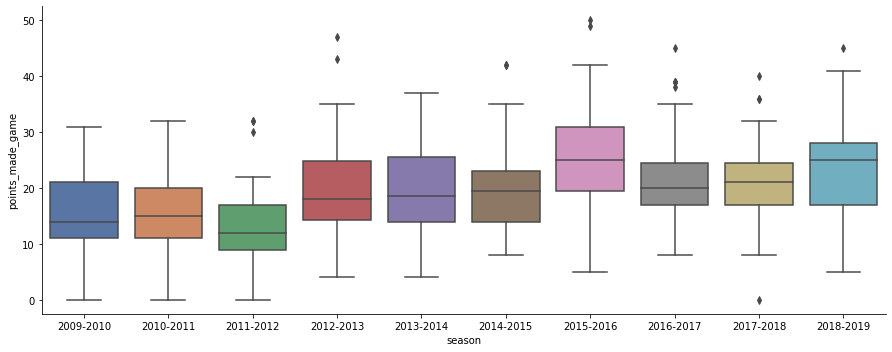

In [43]:
sns.catplot(data=shotsSeason, kind='box', x='season', y='points_made_game', 
            aspect=2.5, palette='deep')

In [44]:
shotsSeason.head()

,season,game_date,points_made_game,shots_made,shots_attempted
game_id,,,,,
0020900015,2009-2010,2009-10-28,14,7,12
0020900030,2009-2010,2009-10-30,12,5,9
0020900069,2009-2010,2009-11-04,7,3,6
0020900082,2009-2010,2009-11-06,2,1,5
0020900096,2009-2010,2009-11-08,9,4,8


In [45]:
shotsSeasonAvg = shotsSeason.groupby('season').mean().reset_index()
shotsSeasonAvg

,season,points_made_game,shots_made,shots_attempted
0,2009-2010,15.430380,6.670886,14.455696
1,2010-2011,15.567568,6.770270,14.108108
2,2011-2012,13.800000,5.800000,11.720000
3,2012-2013,19.423077,7.974359,17.641026
4,2013-2014,19.884615,8.282051,17.525641
5,2014-2015,19.750000,8.100000,16.675000
6,2015-2016,25.189873,10.075949,19.949367
7,2016-2017,21.050633,8.493671,18.113924
8,2017-2018,20.784314,8.333333,16.882353
9,2018-2019,23.217391,9.072464,19.260870


<AxesSubplot:xlabel='season'>

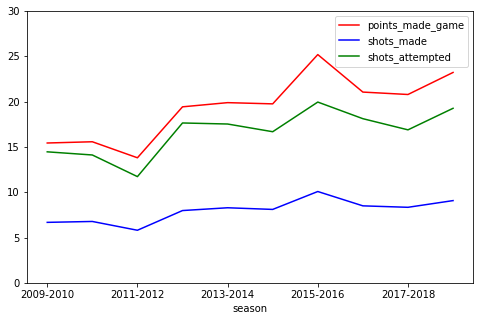

In [46]:
shotsSeasonAvg.plot(
    x='season', y=['points_made_game','shots_made','shots_attempted'], 
    color={'points_made_game':'red','shots_made':'blue','shots_attempted':'green'}, 
    figsize=(8,5), ylim=(0,30))

## Plot the shots for two games

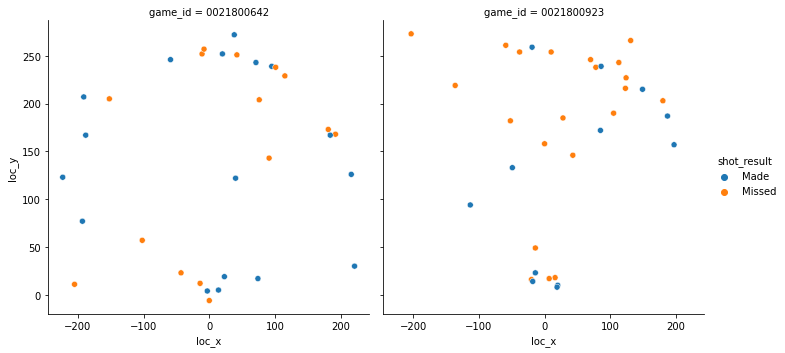

In [47]:
# two games with a lot of shots
gameIDs = ['0021800923','0021800642']
g = sns.relplot(data=shots.query('game_id in @gameIDs'), kind='scatter', 
    x='loc_x', y='loc_y', hue='shot_result', col='game_id')

In [48]:
# SOURCE: http://savvastjortjoglou.com/nba-shot-sharts.html
from matplotlib.patches import Circle, Rectangle, Arc
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

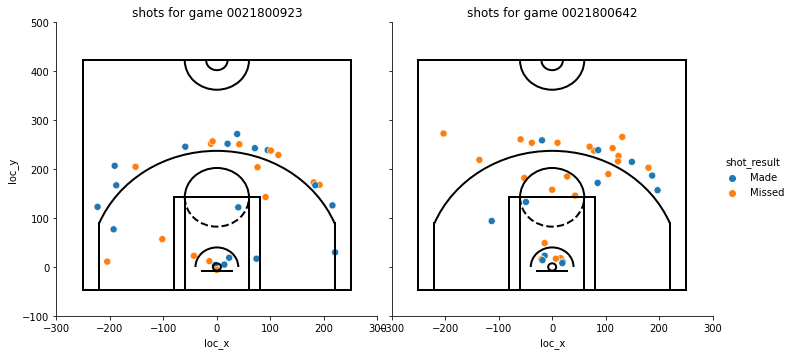

In [49]:
g = sns.relplot(data=shots.query('game_id in @gameIDs'), kind='scatter', 
    x='loc_x', y='loc_y', hue='shot_result', col='game_id', s=50)

for i, ax in enumerate(g.axes.flat):
    ax.set_title('shots for game ' + gameIDs[i])
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300,300)
    ax.set_ylim(-100, 500)

## Plot shot data for two seasons

In [ ]:
colors = ['#FF0B04','#4374B3'] # blue and red
sns.set_palette(sns.color_palette(colors))

seasons = ['2009-2010','2018-2019']
g = sns.relplot(data=shots.query('season in @seasons'), kind='scatter', 
    x='loc_x', y='loc_y', hue='shot_result', col='season', col_wrap=1)

for ax in g.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300, 300)
    ax.set_ylim(-100, 500)

## Plot shot density for one season

In [ ]:
colors = ['#4374B3','#FF0B04'] # red and blue
sns.set_palette(sns.color_palette(colors))

g = sns.displot(data=shots.query('season == "2015-2016"'), kind='kde', legend=False,
    x='loc_x', y='loc_y', col='shot_result', hue='shot_result', col_wrap=1)

for ax in g.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300, 300)
    ax.set_ylim(-100, 500)

## Plot shot density for two seasons

In [ ]:
colors = ['#FF0B04','#4374B3'] # blue and red
sns.set_palette(sns.color_palette(colors))

seasons = ['2009-2010','2015-2016']
g = sns.displot(data=shots.query('season in @seasons'), kind='kde', 
                x='loc_x', y='loc_y', row='shot_result', col='season', 
                hue='shot_result', legend=False)
for ax in g.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300, 300)
    ax.set_ylim(-100, 500)